# Investigating the composition of academics in economics

In this notebook we scrape information on a random sample of academic economists from the Ideas website. We retrieve information on their publishing record, journals in which they have published and detailed information on each of their publications. 

We show simple descriptive statistics from this dataset. There are approximately 50.000 authors total registered on Ideas, but due to time constraints we restict ourselves to around 8.000 observations. This becomes especially problematic in the network analysis.

*Note* a lot of the code is very time consuming to run. We supply a static pdf/html containing the results. If you want to run this notebook for yourself, be sure to follow good scraping practices.

In [1]:
import re 
import os
import string
from time import sleep
from collections import Counter

import pandas as pd 
import numpy as np 

import networkx as nx

import requests 
from bs4 import BeautifulSoup

import pretty        
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns 

from dataproject import (retrieve, 
                         build, 
                         parallelize,
                         visuals, 
                         simulate)

In [2]:
# These are just some helper config things.
# they shouldn't be played around with to
# much unless you want to replicate the 
# notebook from scratch. If so, set 
# RUN_SCRAPER = True and BUILD_DATA = True

RUN_SCRAPER = False       # Run the scraper? (approx 10hrs for 5k obs)
BUILD_DATA  = False        # Build dataset from all 7000 files?
SAMPLE      = False       # Sample authors?  (for testing)
VISUALIZE   = True        # Show visualizations?

First we scrape the complete list of authors on Ideas.RePec. We use our `cached()` function to avoid reloading data from the webserver every time the script is run. We remove any missing observations that show up because the scraper is a bit broad in it's selection criteria.

In [3]:
authors = retrieve.cached(retrieve.get_authors, path = 'data/authors.csv')
authors = authors.dropna()

if SAMPLE:
    authors = authors.sample(1000)

Read from file.


Next we convert the number of publications into an integer (it is stored in a string formatted like such `(x)`) and remove authors with 0 or unknown number of publications. The people with 0 publications will not enter the following analysis anyways.

In [4]:
def asInteger(s):
    nums = re.findall(r'\d+', s)
    if len(nums)>0:
        return int(''.join(nums))
    return 0

authors['pubs'] = authors['pubs'].apply(asInteger)
authors = authors.query("pubs > 0")


To get a sense of the data we plot the density of publication counts.

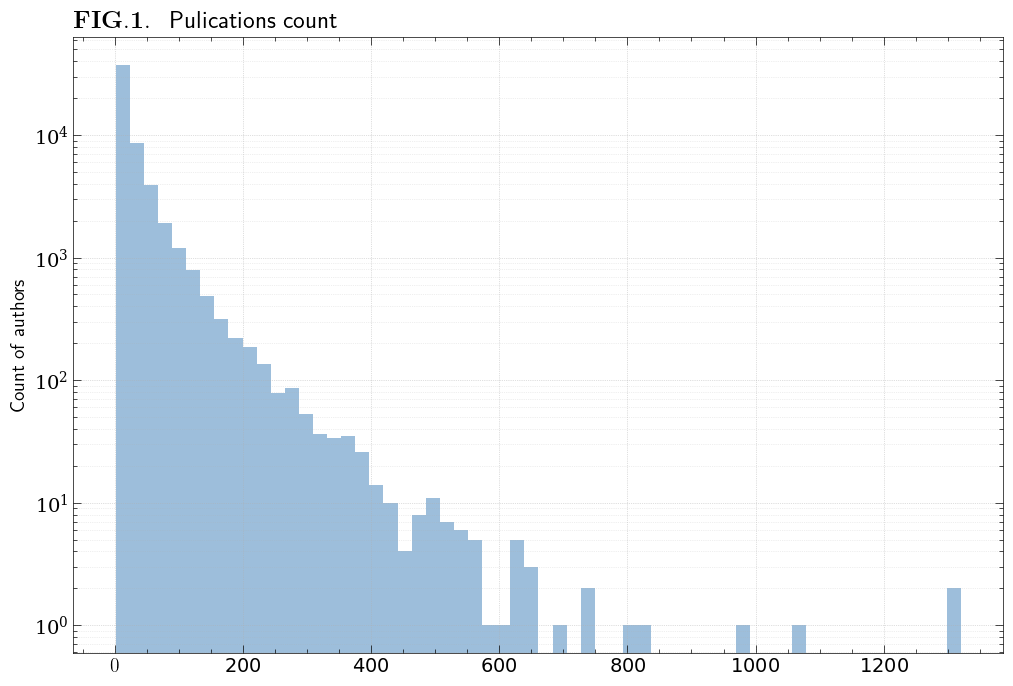

In [5]:
if VISUALIZE:
    visuals.PublicationsHistogram(authors)
    plt.show()

From this alone we learn quite a lot. First of, it seems it is most common to have 1 publication in total, this suggests quite heavy selection into academic careers. Second, the top published in terms of $N$ have an insane number of publications. The highest $N$ is held by [Peter Nijkamp](https://en.wikipedia.org/wiki/Peter_Nijkamp).

Now we need to get information on the collaborations of each author. To do this i will scrape the individual author pages. There is quite a lot of data here, so run it at your own discression. 

In [6]:
from sklearn.utils import shuffle
authors = shuffle(authors)

if RUN_SCRAPER:
    i = 0
    for url, name in zip(authors.url, authors.name):
        i += 1
        if i % 50 == 0:
            sleep(20)
        if i % 20 == 0:
            print(f"---- {i} ----\n")
        sleep(5)    
        name = ''.join(re.findall('[A-Za-z]+', name))
        data = retrieve.cached(retrieve.get_author_work, f'data/authorsWork/{name}.csv', url)

Now to pull data from the individual author datasets simply apply the `build` function across all rows. The function can be found in src/datawork/build.py. Specifically we extract information on 

**1)** The coauthors of each author. 

**2)** The Journals in which each author has published.

**3)** The share of publications on which the author is first author.

In [7]:
if BUILD_DATA: 
    def build_(data):
        'Helper to allow parallel execution'
        return data.apply(build, axis = 1)

    authors = parallelize(authors, build_, cores = 6) 
    
    authors['n_coauthors'] = authors.coauthors.apply(len)
    authors['n_journals'] = authors.unique_journals.apply(len)
    authors.to_pickle('data/buildfile.pckl')
else:
    authors = pd.read_pickle('data/buildfile.pckl')
    
    if SAMPLE:
        authors = authors.sample(1000)

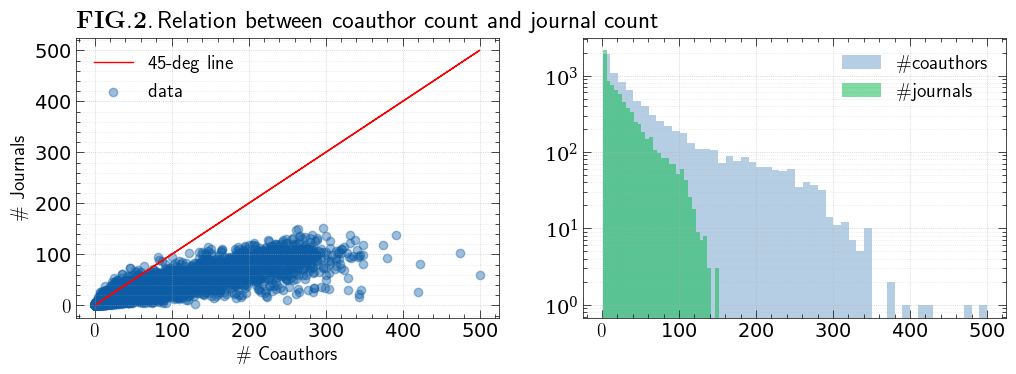

In [8]:
if VISUALIZE:
    visuals.SplitCountPlot(authors)
    plt.show()

Now lets turn our attention towards the importance of being first author on academic achievement. I begin by plotting the average number of publications and coauthors across the first letter of authors name. Note i take the first letter simply to be the first one that appears in the raw data. As an example an author who is listed as "Andersen, Jens" will have first letter "A" while one who is listed as "Jens andersen" will have first letter "J". I am fairly certain that the format supplied on Ideas follow the way authors are cited in publications, but this method is still only approximate. 

In [9]:
converter = {l: n for l,n in zip(string.ascii_lowercase, range(len(string.ascii_lowercase)))}

def convert(l):
    try:
        return converter[l.lower()]
    except KeyError:
        return -1
    

authors['firstLetter'] = authors.name.apply(lambda x: x[0].lower())
authors['firstLetterIdx'] = authors.firstLetter.apply(convert)


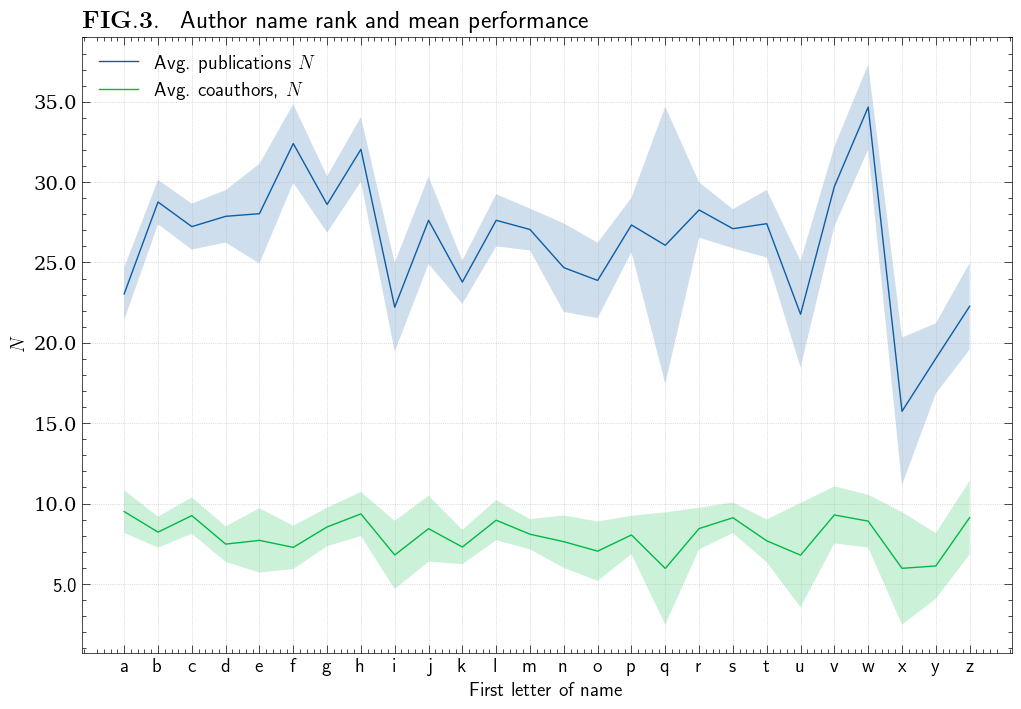

In [10]:
if VISUALIZE:
    visuals.plotByFirstLetter(authors)
    plt.show()

Which doesn't seem to show any major differences across the board. (i do use the first letter of their name as listed on Ideas, so this should be how they are written in references. 

## Authors alphabetical position and their publication performance
We know that neither the number of coauthors or publications are closely related to the first letter of the alphabet, but as an aside i show here that the probability of being first author is decreasing in ones first-letter, and simulate the theoretical relationship between first-letter and probability of being first author.

Specifically we model this by assuming that each paper contains $k$ authors, represented as a letter in the english alphabet who are drawn independently according to the empirical distribution of author first-letters. 

From these $k$ authors we check if they would be first-author following alphabetical ranking, and add 1 to their total score if this is the case. The simulation is run for $k=3,5,7$.

In [11]:
data_3auth = simulate.simulate(authors, n_authors = 3, rounds = 50000)
data_5auth = simulate.simulate(authors, n_authors = 5, rounds = 50000)
data_7auth = simulate.simulate(authors, n_authors = 7, rounds = 50000)


In [12]:
def calculate_stats(datadict):
    mean = {k:np.mean(v) for k,v in datadict.items()}
    sd_lo = {k:np.mean(v) - 1.96 * np.std(v, ddof = 1)/np.sqrt(len(v)) for k,v in datadict.items()}
    sd_hi = {k:np.mean(v) + 1.96 * np.std(v, ddof = 1)/np.sqrt(len(v)) for k,v in datadict.items()}
    
    return mean, sd_lo, sd_hi

In [13]:
mean3, sdlo3, sdhi3 = calculate_stats(data_3auth)
mean5, sdlo5, sdhi5 = calculate_stats(data_5auth)
mean7, sdlo7, sdhi7 = calculate_stats(data_7auth)

In this figure we show the empirical density of first-authorship across first letter along with simulations for three fixed author group sizes. Clearly the empirical distribution does not follow the same random process as our simulation, but there is some decline towards the end of the alphabet, suggesting there is at least some alphabetical sorting going on.

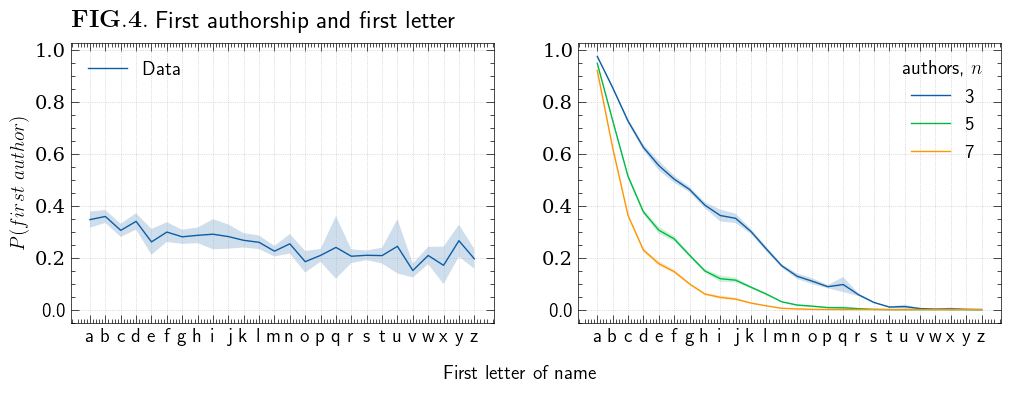

In [14]:
visuals.ProbabilityByFirstLetter(authors.query("share_first > -.1"), means = (mean3, mean5, mean7),
                                 low = (sdlo3, sdlo5, sdlo7), high = (sdhi3, sdhi5, sdhi7)) 
plt.show()

## Author network structure

In this section we construct a network of authors, where edges represent two authors having coauthored at least one paper. 

Because the data are quite noisy we make the match between coauthors not based on their actual names, but rather alphabetically sort all characters in their names, and match on the sorted "names". This removes the problem that authors names might sometimes be written "Jim John" and other times "John, Jim". 

In [15]:
data = authors.query("n_journals > 0")

First i reshape the dataset to contain all unique author-author pairs. I convert the variables to categories to avoid eating all RAM available and merge the data with itself to get all author-author pairs who have published together. Finally i remove self-matches (of course authors have published in the same journals as themself). I also remove reverse links, so if a pair A-B is in the data already i drop the pair B-A.

In [16]:
rows = [(d, tup.name) for tup in data[['name', 'coauthors']].itertuples() for d in tup.coauthors]
reshaped = pd.DataFrame(rows, columns = ['coauthor', 'author'])

In [17]:
def fixCoauthor(x):
    return ''.join(sorted(''.join([n for n in x])))

def fixAuthor(x):
    author = ''.join(re.findall('[A-Za-z\s]*', x)).strip().lower()
    return ''.join(sorted(author)).strip()

reshaped['coauthor_sort'] = reshaped.coauthor.apply(fixCoauthor)
reshaped['author_sort'] = reshaped.author.apply(fixAuthor)

reshaped = reshaped[reshaped.author_sort != reshaped.coauthor_sort]

In [18]:
# remove A-B, B-A duplicates
reshaped['temp'] = reshaped[['author_sort', 'coauthor_sort']].apply(sorted, axis = 1).apply(lambda x: ''.join(x))
reshaped = reshaped.drop_duplicates(subset = ['temp']).drop('temp', axis = 1).reset_index()

Now from this data i'm ready to create a graph, first let us look at the degree distribution of the graph. The probabilities are rescaled just because matplotlib isn't fond of very small numbers. 

In [19]:
G = nx.from_pandas_edgelist(reshaped, source = 'author_sort', target = 'coauthor_sort', create_using = nx.Graph())

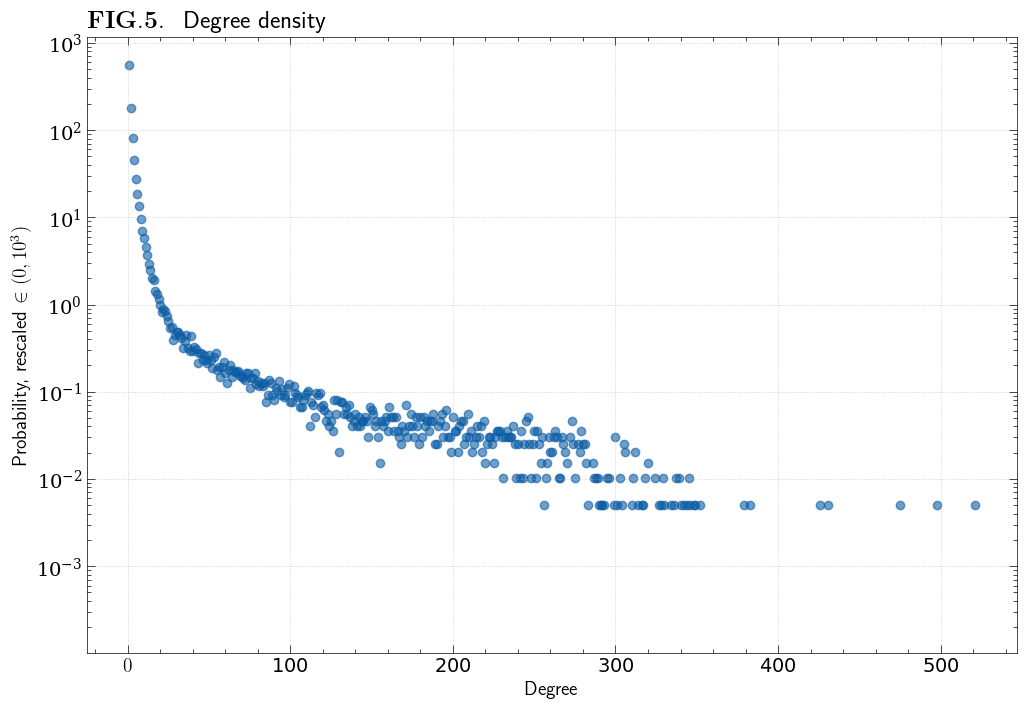

In [20]:
degdens = Counter(dict(G.degree()).values())
total =  sum(degdens.values())
degree_data = {k: 1000 * v / total for k,v in sorted(degdens.items())}

with pretty.Classic():
    fig = plt.figure(figsize = (12,8))    
    ax = fig.add_subplot(1, 1, 1)
    
    ax.scatter(degree_data.keys(), degree_data.values(), alpha = .6)
    ax.set_yscale('log')

    ax.set_xlabel("Degree")
    ax.set_ylabel("Probability, rescaled $\in (0, 10^3)$")

    ax.annotate('$\mathbf{FIG.5.}$', xy=(0, 1.015), xycoords='axes fraction', ha='left',
            fontsize=18, annotation_clip=False)
    ax.annotate('Degree density', xy=(0.105, 1.015), xycoords='axes fraction', ha='left',
            fontsize=18, annotation_clip=False)
    
    ax.grid(which='major', alpha=0.8, linestyle='dotted')